In [3]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
# File with public supply total GW + SW
usgs_2020 = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\PS_HUC12_GW_2000_2020.csv')
# Machine learning model output for domestic demand per capita
dpc_2020 = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\delivery_water_use_model\predictions\national_dpc_predictions.csv')
# Baseline water treatment train files
wt_baseline = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_wt_baseline_spreadsheet.csv')
# Read state and county shapefiles
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")
us_states = gp.read_file(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files\tl_rd22_us_state\tl_rd22_us_state.shp')
us_states = us_states.to_crs("EPSG:4326")
# USGS 2017 data for WSA
usgs_wsa = gp.read_file(r'C:\Users\mhardika\Downloads\WSA_v1\WSA_v1\WSA_v1.shp')
usgs_gu_wwsa = gp.read_file(r'C:\Users\mhardika\Downloads\V1_GU_wWS\V1_GU_wWS\v1_GU_wWS.shp')
# Population data set
pop_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\pop_projection.csv')
pop_df = pop_df[~(pop_df == 0).any(axis=1)].reset_index(drop=True)

state_geocode = pd.read_csv(r'C:\Users\mhardika\Documents\watertap3\WaterTAP3\watertap3\watertap3\data\state_geocode.csv')

In [36]:
wt_facilities_no_filter = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv')
wt_facilities_no_filter.head(2)

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21448\151730665.py:1: DtypeWarning: Columns (12,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  wt_facilities_no_filter = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv')


,PWS ID,PWS Name,Facility Id,Facility Name,EPA Region,Primacy Agency,Facility Type Description,Is Source Ind,Activity Status,Deactivation Date,...,Season End Date,Population Served Count,Service Connections Count,Is Wholesaler,Seller Pwsid,Seller Pws Name,Seller Treatment Description,Filtration Status Description,Treatment Process,Treatment Objective
0,AR0000601,DARDANELLE WATERWORKS,780,WTP ONLY ACTIVE PLANT,Region 6,Arkansas,Treatment Plant,N,Active,NaN,...,NaN,4228.0,1618,N,NaN,NaN,NaN,NaN,Activated Alumina,Inorganics removal
1,AR0000604,OLA WATERWORKS,960,MASTER METER,Region 6,Arkansas,Treatment Plant,N,Active,NaN,...,NaN,998.0,415,N,NaN,NaN,NaN,NaN,Activated Alumina,Inorganics removal


In [93]:
wt_baseline_sorted = wt_baseline.sort_values(['PWS ID'])
# wt_baseline_sorted.head(3)

In [39]:
# Baseline water treatment train files
wt_baseline = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_wt_baseline_spreadsheet.csv')
# wt_baseline = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_wt_baseline_flow.csv')
# for idx, row in wt_baseline.tail(10).iterrows():
#     # print(row['PWS ID'][0:2])

#     if row['PWS ID'][0:2].isalpha():
#         # print(row['PWS ID'][0:2])
#         if row['PWS ID'][0:2]!= row['State Code']:
#             print(row)

In [40]:
# Code to reassign wt_baseline facilities to correct state based on PWS ID

# County how many states have the wrong assignment
wrong_state_idx_list=[]
state_list = []
for idx, row in wt_baseline.iterrows():
    # print(row['PWS ID'][0:2])

    if row['PWS ID'][0:2].isalpha():
        # print(row['PWS ID'][0:2])
        if row['PWS ID'][0:2]!= row['State Code']:
            # print(row)
            wrong_state_idx_list.append(idx)
            state_list.append(row['PWS ID'][0:2])

print(len(wrong_state_idx_list))
print(wrong_state_idx_list[0])

# Correcting wt_baseline dataframe
new_df = pd.DataFrame({'State Code': state_list}, index = wrong_state_idx_list)
# new_df
wt_baseline_updated = wt_baseline.copy()
wt_baseline_updated.update(new_df)

wrong_state_idx_list=[]
state_list = []
for idx, row in wt_baseline_updated.iterrows():
    # print(row['PWS ID'][0:2])
    if row['PWS ID'][0:2].isalpha():
        # print(row['PWS ID'][0:2])
        if row['PWS ID'][0:2]!= row['State Code']:
            # print(row)
            wrong_state_idx_list.append(idx)
            state_list.append(row['PWS ID'][0:2])

print(len(wrong_state_idx_list))

wt_baseline = wt_baseline_updated.copy()

995
462
0


In [88]:
sdwis_cws_ny = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\testing_sdwis_dataset\sdwis_cws_ny.csv')
print(len(sdwis_cws_ny))
sdwis_cws_ny = sdwis_cws_ny.loc[sdwis_cws_ny['Facility Type Description']=='Treatment Plant']
sdwis_cws_ny = sdwis_cws_ny.loc[sdwis_cws_ny['Facility Activity']=='Active']
sdwis_cws_ny = sdwis_cws_ny.drop_duplicates(subset = ['PWS ID'])
print(len(sdwis_cws_ny))
sdwis_cws_ny.head(2)
print(len(wt_baseline_updated.loc[wt_baseline_updated['State Code']=='NY']))

25171
1856
1837


In [74]:
wt_baseline.head(2)

,PWS ID,PWS Name,Population Served Count,Activity Status,Primary Source,PWS Type,City Name,State Code,Zip Code,Latitude,...,"Ozonation, Post","Ozonation, Pre",Permanganate,Peroxide,Rapid Mix,Reverse Osmosis,Sedimentation,Sequestration,Sludge Treatment,Ultraviolet Radiation
0,010106001,Mashantucket Pequot Water System,37807,Active,Groundwater under influence of surface water,Community water system,MASHANTUCKET,CT,06339-3060,41.46446,...,0,0,0,0,0,0,1,0,0,0
1,010307001,Aquinnah Wampanoag,103,Active,Ground water,Community water system,CHILMARK,MA,02535,NaN,...,0,0,0,0,0,0,0,0,0,0


USGS Data Analysis Datasets:
1. 2000-2020 HUC dataset
2. National DPC modeled using the 2000-2020 dataset
3. WSA dataset with poylgons describing service area and population in each service area. (what year?)
4. A more details geographical unit (GU) data set

In [6]:
# usgs_gu_wwsa.loc[1]

In [6]:
# wt_baseline.head(2)

In [41]:
usgs_wsa_sorted = usgs_wsa.sort_values('WSA_AGIDF')
usgs_wsa_sorted.head(2)
# usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']=='WA5324164']

,WSA_AGIDF,POLY_COUNT,WSA_SQKM,TPOLYPOP,TPOPSRV,STATE_NAME,WSA_NAME,geometry
0,010106001,1,6.614479,48836,48836,Connecticut,Mashantucket Pequot Water System,MULTIPOLYGON Z (((1971505.428 2299647.812 0.00...
1,042800001,1,16.572056,887,1072,Mississippi,CHOCTAW - BOGUE CHITTO,"POLYGON Z ((658697.443 1110800.061 0.000, 6587..."


In [42]:
# wt_baseline[wt_baseline['State Code']=='CA']
# usgs_wsa_sorted.loc[usgs_wsa_sorted['TPOPSRV']<25]
wt_baseline = wt_baseline.loc[wt_baseline['Population Served Count']>25].copy()
combined_df = pd.DataFrame()
# Grab PWS ID and WSA from SDWIS and USGS data
pws_id = wt_baseline['PWS ID'].values
wsa = usgs_wsa_sorted['WSA_AGIDF'].values

all_wsa_pwd = np.concatenate([wsa,pws_id])
combined_df['combined_ids'] = all_wsa_pwd
combined_df.drop_duplicates('combined_ids',inplace=True)
combined_df.dropna(inplace=True)

combined_df.reset_index(inplace=True)
combined_df.drop(columns='index',inplace=True)
print('SDWIS data:',len(pws_id))
print('USGS data:',len(wsa))
print('Combined:',len(combined_df['combined_ids']))

SDWIS data: 35476
USGS data: 18806
Combined: 37946


In [141]:
usgs_wsa_sorted['WSA_AGIDF'][0]
# wt_baseline['PWS ID'][0]

# usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']=='042800002']['TPOPSRV'].values[0]
wt_baseline[wt_baseline['PWS ID']=='042800002']['Population Served Count'].values[0]

820

In [43]:
# List of facilities at are inactive in the sdwis dataset
wt_facilities_no_filter_inactive = wt_facilities_no_filter.loc[wt_facilities_no_filter['Facility Activity']=='Inactive']
wt_facilities_no_filter_inactive = wt_facilities_no_filter_inactive.drop_duplicates(subset=['PWS ID'])
inactive_pws_id_list = []
for idx, row in wt_facilities_no_filter_inactive.iterrows():
    if row['PWS ID'] in combined_df['combined_ids'].values:
        # print(row['PWS ID'])
        inactive_pws_id_list.append(row['PWS ID'])


In [38]:
# Filter list facilities from both SDWIS and USGS (DPC) and list where they exist
# Comparison of USGS and SDWIS data of population

combined_df = pd.DataFrame()
# Grab PWS ID and WSA from SDWIS and USGS data
pws_id = wt_baseline['PWS ID'].values
pws_inactive_id = wt_facilities_no_filter_inactive['PWS ID'].values
wsa = usgs_wsa_sorted['WSA_AGIDF'].values

all_wsa_pwd = np.concatenate([wsa,pws_id,pws_inactive_id])
combined_df['combined_ids'] = all_wsa_pwd
combined_df.drop_duplicates('combined_ids',inplace=True)
combined_df.dropna(inplace=True)

combined_df.reset_index(inplace=True)
combined_df.drop(columns='index',inplace=True)
print('SDWIS data:',len(pws_id))
print('USGS data:',len(wsa))
print('Combined:',len(combined_df['combined_ids']))

usgs_pop_list = []
sdwis_pop_list = []
state_code_list = []
usgs_check_list = []
sdwis_check_list = []
sdwis_inactive_check_list = []

for idx,row in combined_df.iterrows():
    state = []

    # Check if the facility in SDWIS active facilities list
    if row['combined_ids'] in wt_baseline['PWS ID'].values:
        sdwis_check_list.append(1)
        sdwis_inactive_check_list.append(0)
        sdwis_pop_list.append(wt_baseline[wt_baseline['PWS ID']==row['combined_ids']]['Population Served Count'].values[0])
        state = wt_baseline[wt_baseline['PWS ID']==row['combined_ids']]['State Code'].values[0]
    # Check if the facility in the SDWIS inactive facility list
    elif row['combined_ids'] in wt_facilities_no_filter_inactive['PWS ID'].values:
        sdwis_inactive_check_list.append(1)
        sdwis_check_list.append(0)
        sdwis_pop_list.append(wt_facilities_no_filter_inactive[wt_facilities_no_filter_inactive['PWS ID']==row['combined_ids']]['Population Served Count'].values[0])
        state = wt_facilities_no_filter_inactive[wt_facilities_no_filter_inactive['PWS ID']==row['combined_ids']]['Primacy Agency'].values[0]
    else:
        sdwis_check_list.append(0)
        sdwis_inactive_check_list.append(0)
        sdwis_pop_list.append(0)
        state_name = usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['STATE_NAME'].values[0]
        state = state_geocode[state_geocode['state']==state_name]['abbv'].values[0]
        # state_code_list.append()

    if row['combined_ids'] in usgs_wsa_sorted['WSA_AGIDF'].values:
        usgs_check_list.append(1)
        usgs_pop_list.append(usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['TPOPSRV'].values[0])
        state_name= usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['STATE_NAME'].values[0]
        state = state_geocode[state_geocode['state']==state_name]['abbv'].values[0]
        # state_code_list.append(usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['STATE_NAME'].values[0])
    else:
        usgs_check_list.append(0)
        usgs_pop_list.append(0)
    state_code_list.append(state)

combined_df['usgs_check'] = usgs_check_list
combined_df['sdwis_check'] = sdwis_check_list
combined_df['sdwis_inactive_check'] = sdwis_inactive_check_list
combined_df['usgs_pop'] = usgs_pop_list
combined_df['sdwis_pop'] = sdwis_pop_list
combined_df['state_code'] = state_code_list

# combined_df.reset_index(inplace=True)
combined_df

SDWIS data: 36020
USGS data: 18806
Combined: 38319


KeyboardInterrupt: 

In [1]:
len(inactive_pws_id_list)
inactive_pws_id_list[0]

combined_df[combined_df['combined_ids']==inactive_pws_id_list[0]]

NameError: name 'inactive_pws_id_list' is not defined

In [2]:
# # combined_df_ny['sdwis_pop'].values
# fig, ax = plt.subplots()
# x = np.arange(0,len(combined_df_state))
# # print(x,len(combined_df_ny))
# ax.bar(x+0.15, combined_df_state['sdwis_pop'],width=0.3,label='SDWIS')
# ax.bar(x-0.15, combined_df_state['usgs_pop'],width=0.3,label='USGS')
# ax.set_yscale('log')
# ax.set_xlim([750,800])
# ax.legend()


In [118]:
# Going through all states and checking things

combined_state_wise_df = pd.DataFrame()

state_code_list = []
usgs_state_pop_list = []
sdwis_state_pop_list = []
hauer_state_pop_list = []
sdwis_only_list = []
usgs_only_list = []
usgs_sdwis_inactive_list = []
common_facilities_list = []
contiguous_usa = ('AL','AZ','AR','CA','CO','CT','DE','FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY','DC')


for state in contiguous_usa:
    state_code_list.append(state)
    combined_df_state = combined_df.loc[(combined_df['state_code']==state)]
    usgs_state_pop_list.append(combined_df_state['usgs_pop'].sum())
    sdwis_state_pop_list.append(combined_df_state['sdwis_pop'].sum())
    
    state_id = state_geocode[state_geocode['abbv']==state]['state_id'].values[0]
    pop_df_state = pop_df.loc[pop_df['state_id']==state_id].copy()
    hauer_state_pop_list.append(pop_df_state['ssp22020'].sum())
    sdwis_only_list.append(len(combined_df_state[(combined_df_state['sdwis_check']==1) & (combined_df_state['usgs_check']==0)]))
    usgs_only_list.append(len(combined_df_state[(combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]))
    usgs_sdwis_inactive_list.append(len(combined_df_state[(combined_df_state['sdwis_inactive_check']==1) & (combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]))
    common_facilities_list.append(len(combined_df_state[(combined_df_state['sdwis_check']==1) & (combined_df_state['usgs_check']==1)]))
    
combined_state_wise_df['state_code'] = state_code_list
combined_state_wise_df['usgs_state_pop'] = usgs_state_pop_list
combined_state_wise_df['sdwis_state_pop'] = sdwis_state_pop_list
combined_state_wise_df['hauer_state_pop'] = hauer_state_pop_list
combined_state_wise_df['sdwis_only'] = sdwis_only_list
combined_state_wise_df['usgs_only'] = usgs_only_list
combined_state_wise_df['usgs_inactive'] = usgs_sdwis_inactive_list
combined_state_wise_df['common_facilities'] = common_facilities_list

combined_state_wise_df.head(2)


,state_code,usgs_state_pop,sdwis_state_pop,hauer_state_pop,sdwis_only,usgs_only,usgs_inactive,common_facilities
0,AL,3.200455e+06,5318698.0,4.959771e+06,93,15,1,272
1,AZ,6.677942e+06,6687964.0,7.300009e+06,330,102,28,283


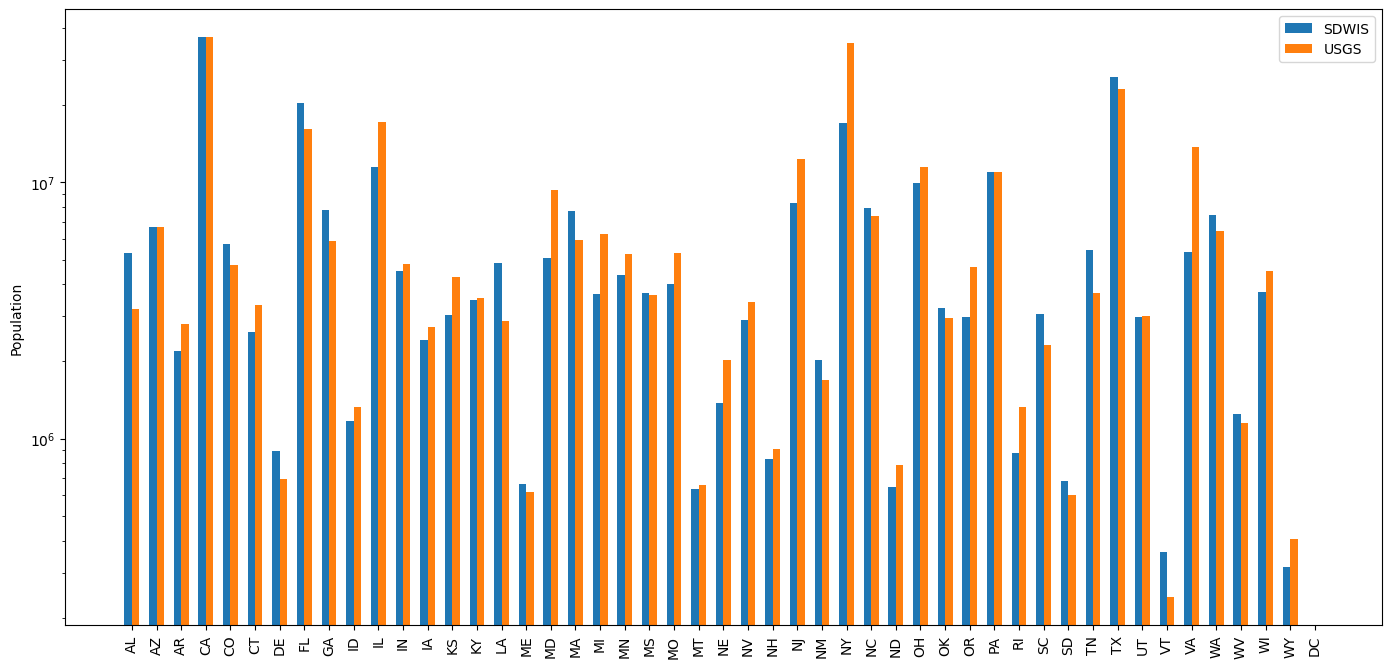

In [115]:
fig, ax = plt.subplots(figsize=(17,8))
x = np.arange(0,len(combined_state_wise_df))
# print(x,len(combined_df_ny))
ax.bar(x-0.15, combined_state_wise_df['sdwis_state_pop'],width=0.3,label='SDWIS')
ax.bar(x+0.15, combined_state_wise_df['usgs_state_pop'],width=0.3,label='USGS')
ax.set_yscale('log')
ax.set_xticks(range(0,len(contiguous_usa)),contiguous_usa,rotation = 90)
# ax.set_xlim([750,800])
ax.set_ylabel('Population')
ax.legend()

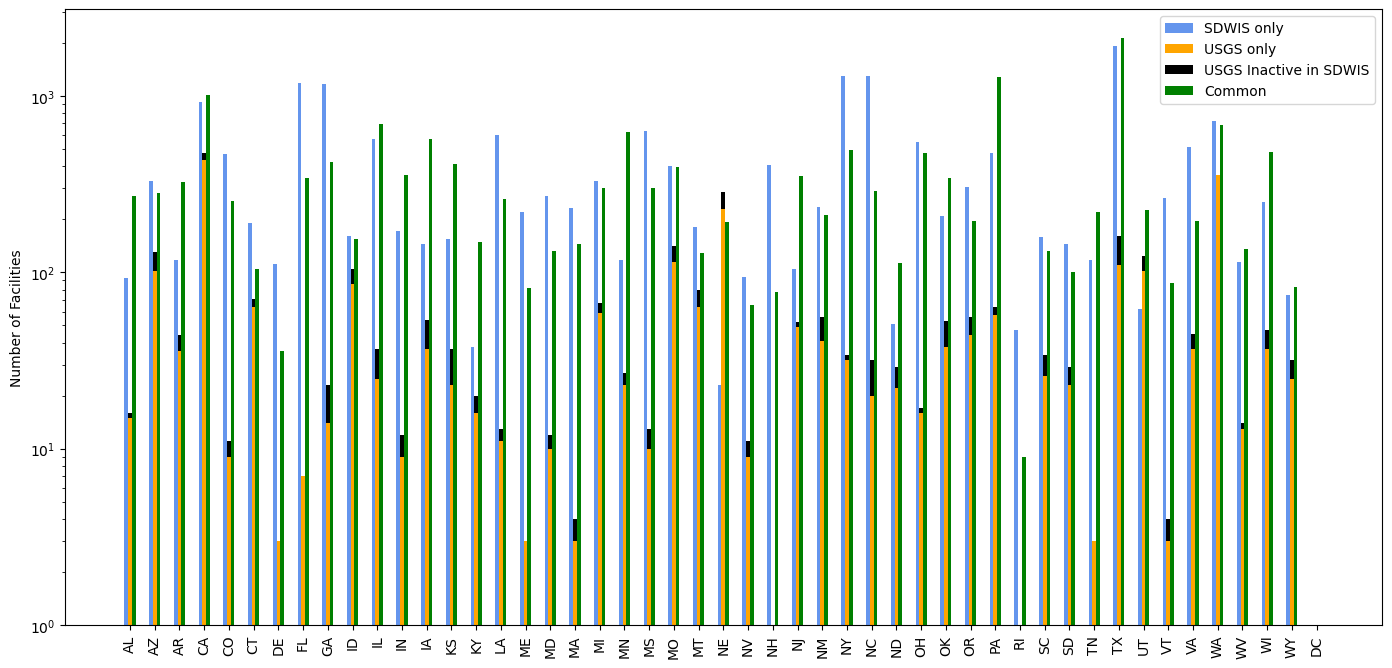

In [121]:
fig, ax = plt.subplots(figsize=(17,8))
x = np.arange(0,len(combined_state_wise_df))
# print(x,len(combined_df_ny))
ax.bar(x-0.15, combined_state_wise_df['sdwis_only'],width=0.15,label='SDWIS only',color = 'cornflowerblue')
ax.bar(x, combined_state_wise_df['usgs_only'],width=0.15,label='USGS only',color = 'orange')
ax.bar(x, combined_state_wise_df['usgs_inactive'],bottom=combined_state_wise_df['usgs_only'], width=0.15,label='USGS Inactive in SDWIS',color = 'black')

ax.bar(x+0.15, combined_state_wise_df['common_facilities'],width=0.15,label='Common',color = 'green')
ax.set_yscale('log')
ax.set_xticks(range(0,len(contiguous_usa)),contiguous_usa,rotation = 90)
# ax.set_xlim([750,800])
ax.set_ylabel('Number of Facilities')
ax.legend()

In [ ]:
# Checking population for New York
state_code = 'NY'
combined_df_state = combined_df.loc[(combined_df['state_code']==state_code)]

In [80]:
print('SDWIS',combined_df_state['sdwis_pop'].sum())
print('USGS',combined_df_state['usgs_pop'].sum())

state_id = state_geocode[state_geocode['abbv']==state_code]['state_id'].values[0]
print(state_id)
pop_df_state = pop_df.loc[pop_df['state_id']==state_id].copy()
print('Hauer population data',round(pop_df_state['ssp22020'].sum()))

SDWIS 16991394
USGS 19069247
36
Hauer population data 20242666


In [81]:
# Count number of facilities only in SDWIS
print('Facilities in SDWIS not in USGS', len(combined_df_state[(combined_df_state['sdwis_check']==1) & (combined_df_state['usgs_check']==0)]))
print('Facilities in USGS not in SDWIS', len(combined_df_state[(combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]))

# Count number of facilities where population is very different

Facilities in SDWIS not in USGS 1337
Facilities in USGS not in SDWIS 28


In [296]:
combined_df_state[(combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]

,combined_ids,usgs_check,sdwis_check,usgs_pop,sdwis_pop,state_code
141,430516073353600,1,0,605,0,NY
143,936000000355,1,0,18871,0,NY
10682,NY0200315,1,0,1040,0,NY
10687,NY0200324,1,0,600,0,NY
10702,NY0400338,1,0,520,0,NY
10710,NY0400352,1,0,870,0,NY
10715,NY0501716,1,0,600,0,NY
10720,NY0600353,1,0,5185,0,NY
10748,NY0900213,1,0,1228,0,NY
10789,NY1302774,1,0,85000,0,NY


In [ ]:
combined_state_wise_df['']

In [83]:
len(combined_df.loc[(combined_df['state_code']=='AL')])
14+127+273

414

In [78]:
# usgs_gu_wwsa_state = usgs_gu_wwsa.loc[usgs_gu_wwsa['STATE_NAME']=='New York']

# geodf_gu_wwsa = gp.GeoDataFrame(usgs_gu_wwsa_state, geometry=usgs_gu_wwsa_state['geometry'])
# geodf_gu_wwsa = geodf_gu_wwsa.to_crs(crs="EPSG:4326")
# fig, ax = plt.subplots(figsize=(7,5))
# ax.axis('off')

# # Add this to include other counties in Georgia
# geodf_gu_wwsa.plot(ax = ax , edgecolor='black')
# state_border = us_states.loc[us_states['STATEFP']=='36']
# state_geo = us_counties.loc[us_counties['STATEFP']=='36']
# state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
# state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

In [79]:
# geodf_wsa = gp.GeoDataFrame(usgs_wsa_state, geometry=usgs_wsa_state['geometry'])
# geodf_wsa = geodf_wsa.to_crs(crs="EPSG:4326")
# fig, ax = plt.subplots(figsize=(7,5))
# ax.axis('off')

# # Add this to include other counties in Georgia
# # ga_counties.plot(ax=ax,edgecolor='black',facecolor='white')
# geodf_wsa.plot(ax = ax , edgecolor='black')
# state_border = us_states.loc[us_states['STATEFP']=='36']
# state_geo = us_counties.loc[us_counties['STATEFP']=='36']
# state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
# state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

# # # Get dataset for the state
# dpc_2020_no_duplicates = dpc_2020.drop_duplicates('wsa_agidf')
# dpc_2020_no_duplicates_state = dpc_2020_no_duplicates.loc[dpc_2020_no_duplicates['wsa_agidf'].str[0:2]=='ny']
# # dpc_2020_no_duplicates_state.head(5)
# wt_baseline_state = wt_baseline.loc[wt_baseline['PWS ID'].str[0:2]=='NY']
# # wt_baseline_state.head(5)

# # Plot the facilities in MA listed in the USGS dataset
# ax.scatter(dpc_2020_no_duplicates_state['lon'],dpc_2020_no_duplicates_state['lat'],label = 'USGS',s = 3,color='green')

# # Plot the facilities in MA listed in the filtered SDWIS dataset
# ax.scatter(wt_baseline_state['Longitude'],wt_baseline_state['Latitude'],label='SDWIS',s=1)

# ax.legend()



In [81]:
# for idx,row in usgs_wsa.iterrows():
#     if len(row['WSA_AGIDF'])>9:
#         print(row['STATE_NAME'],row['WSA_AGIDF'])

# for idx,row in usgs_gu_wwsa.iterrows():
#     if len(row['WSA_AGIDF'])>9:
#         print(row['STATE_NAME'],row['WSA_AGIDF'])


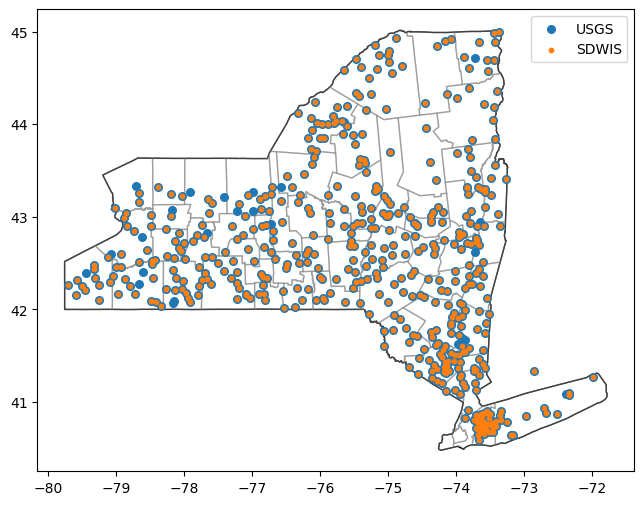

In [86]:
# Checking how many treatment facilities are in a county for the state NY
# Plot the state of MA

state_border = us_states.loc[us_states['STATEFP']=='36']
state_geo = us_counties.loc[us_counties['STATEFP']=='36']

fig, ax = plt.subplots(figsize = (14,6))
state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

# Get dataset for the state
dpc_2020_no_duplicates = dpc_2020.drop_duplicates('wsa_agidf')
dpc_2020_no_duplicates_state = dpc_2020_no_duplicates.loc[dpc_2020_no_duplicates['wsa_agidf'].str[0:2]=='ny']
# dpc_2020_no_duplicates_state.head(5)
wt_baseline_state = wt_baseline.loc[wt_baseline['PWS ID'].str[0:2]=='NY']
# wt_baseline_state.head(5)

# Plot the facilities in MA listed in the USGS dataset
ax.scatter(dpc_2020_no_duplicates_state['lon'],dpc_2020_no_duplicates_state['lat'],label = 'USGS',s = 30)

# Plot the facilities in MA listed in the filtered SDWIS dataset
ax.scatter(wt_baseline_state['Longitude'],wt_baseline_state['Latitude'],label='SDWIS',s=10)

ax.legend()